In [1]:
# This is a Python adaptation from: https://github.com/parsifal9/RFlocalfdr

import sys

import numpy as np
import pandas as pd
import patsy
import scipy
import statsmodels.api as sm

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import patches
plt.rcParams['figure.figsize'] = [15, 10]


from varspark.stats.lfdr import LocalFdrModel


In [2]:
data = pd.read_csv('Letitia_CV_impurity_corrected.tsv', sep='\t')
importances = data.squeeze() #Transforming the dataframe into seriesis
importances.describe()

count    4.283000e+03
mean     6.645013e-01
std      6.656672e-01
min      2.220446e-16
25%      2.043237e-01
50%      4.414963e-01
75%      8.774414e-01
max      8.376121e+00
Name: x, dtype: float64

In [3]:
log_importances = np.log(importances)
log_importances.describe()

count    4283.000000
mean       -0.812965
std         1.050347
min       -36.043653
25%        -1.588050
50%        -0.817586
75%        -0.130745
max         2.125385
Name: x, dtype: float64

In [4]:
fdr_model = LocalFdrModel.fit(log_importances)

/Users/szu004/miniconda3/envs/vs-dev0.5-3.8/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1797: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [7]:
fdr_model

LocalFdrModel(x=array([-35.88461573, -35.56654041, -35.24846509, -34.93038977,
       -34.61231445, -34.29423913, -33.97616381, -33.65808849,
       -33.34001317, -33.02193786, -32.70386254, -32.38578722,
       -32.0677119 , -31.74963658, -31.43156126, -31.11348594,
       -30.79541062, -30.4773353 , -30.15925998, -29.84118466,
       -29.52310934, -29.20503402, -28.8869587 , -28.56888338,
       -28.25080806, -27.93273275, -27.61465743, -27.29658211,
       -26.97850679, -26.66043147, -26.34235615, -26.02428083,
       -25.70620551, -25.38813019, -25.07005487, -24.75197955,
       -24.43390423, -24.11582891, -23.79775359, -23.47967827,
       -23.16160296, -22.84352764, -22.52545232, -22.207377  ,
       -21.88930168, -21.57122636, -21.25315104, -20.93507572,
       -20.6170004 , -20.29892508, -19.98084976, -19.66277444,
       -19.34469912, -19.0266238 , -18.70854848, -18.39047316,
       -18.07239785, -17.75432253, -17.43624721, -17.11817189,
       -16.80009657, -16.48202125, -16.

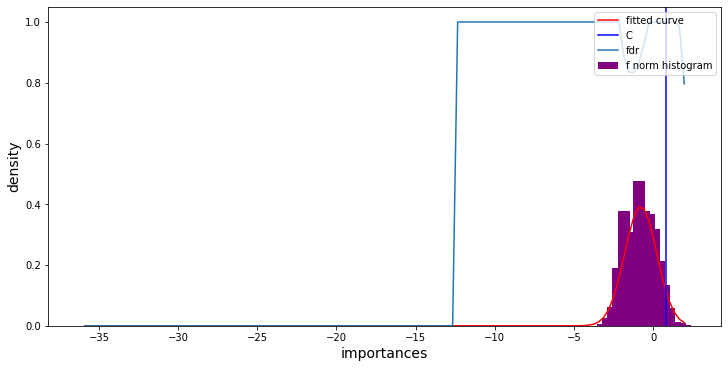

In [6]:
_, ax = plt.subplots(figsize=(10, 5), layout='constrained')
fdr_model.plot(ax)
plt.show()

# With VS

In [ ]:
vds = hl.import_vcf('../data/chr22_1000.vcf')
labels = hl.import_table('../data/chr22-labels-hail.csv', impute = True, delimiter=",").key_by('sample')
vds = vds.annotate_cols(label = labels[vds.s])
vds.cols().show(3)

rf_model = vshl.random_forest_model(y=vds.label['x22_16050408'],
                x=vds.GT.n_alt_alleles(), seed = 13, mtry_fraction = 0.05, min_node_size = 5, max_depth = 10)
rf_model.fit_trees(300, 50)

impTable = rf_model.variable_importance()
fdrCalc = LocalFdrVs.from_imp_table(impTable)


In [ ]:
autoSplitCountTh = fdrCalc.find_split_count_th()
print("The automatically selected SplitCount Threshold is %s" % autoSplitCountTh)

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_densities(ax1,find_automatic_best=False)
plt.show()

In [ ]:
fig, ax2 = plt.subplots(figsize=(10, 5), layout='constrained')
fdrCalc.plot_log_hist(ax2, 2)
plt.show()

In [ ]:
fdrDF, fdr_corrected_cutoff = fdrCalc.compute_fdr(countThreshold = 2, fdr_cutoff = 0.05)
